In [46]:
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy as dc

In [41]:
START = "2010-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

# Define a function to load the dataset
def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data
data = load_data('TCS.NS')
df=data
#df = df.drop(['Date', 'Adj Close'], axis = 1)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,377.399994,379.450012,374.524994,375.825012,283.344482,1963682
1,2010-01-05,377.500000,379.774994,373.274994,375.924988,283.419952,2014488
2,2010-01-06,375.924988,376.100006,366.500000,367.424988,277.011536,3349176
3,2010-01-07,367.750000,369.700012,355.500000,357.200012,269.302643,6474892
4,2010-01-08,358.000000,359.250000,348.250000,349.899994,263.798981,6048178


In [44]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [68]:
data = data[['Date', 'Close']]
data

,Date,Close
0,2010-01-04,375.825012
1,2010-01-05,375.924988
2,2010-01-06,367.424988
3,2010-01-07,357.200012
4,2010-01-08,349.899994
...,...,...
3665,2024-11-08,4147.000000
3666,2024-11-11,4198.700195
3667,2024-11-12,4197.399902
3668,2024-11-13,4150.350098


C:\Users\shive\AppData\Local\Temp\ipykernel_2792\3250349648.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


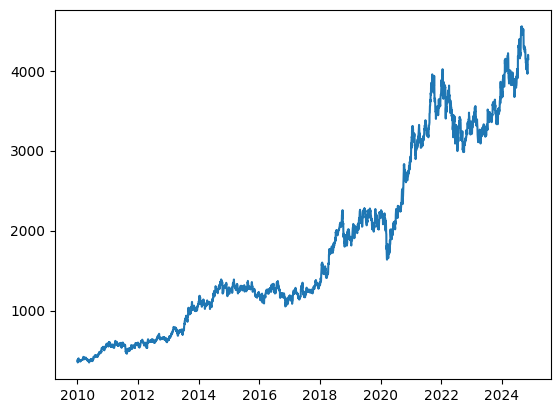

In [69]:
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'], data['Close'])

In [70]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.set_index('Date', inplace=True)
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    df.dropna(inplace=True)
    return df

lookback = 10
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),Close(t-10)
Date,,,,,,,,,,,
2010-01-18,401.100006,395.700012,389.924988,394.274994,375.024994,357.100006,349.899994,357.200012,367.424988,375.924988,375.825012
2010-01-19,390.350006,401.100006,395.700012,389.924988,394.274994,375.024994,357.100006,349.899994,357.200012,367.424988,375.924988
2010-01-20,389.700012,390.350006,401.100006,395.700012,389.924988,394.274994,375.024994,357.100006,349.899994,357.200012,367.424988
2010-01-21,385.325012,389.700012,390.350006,401.100006,395.700012,389.924988,394.274994,375.024994,357.100006,349.899994,357.200012
2010-01-22,378.924988,385.325012,389.700012,390.350006,401.100006,395.700012,389.924988,394.274994,375.024994,357.100006,349.899994


In [71]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[ 401.1000061 ,  395.70001221,  389.92498779, ...,  367.42498779,
         375.92498779,  375.82501221],
       [ 390.3500061 ,  401.1000061 ,  395.70001221, ...,  357.20001221,
         367.42498779,  375.92498779],
       [ 389.70001221,  390.3500061 ,  401.1000061 , ...,  349.8999939 ,
         357.20001221,  367.42498779],
       ...,
       [4197.39990234, 4198.70019531, 4147.        , ..., 3968.44995117,
        4084.64990234, 4075.25      ],
       [4150.35009766, 4197.39990234, 4198.70019531, ..., 3984.19995117,
        3968.44995117, 4084.64990234],
       [4145.89990234, 4150.35009766, 4197.39990234, ..., 3964.14990234,
        3984.19995117, 3968.44995117]])

In [72]:
scaler = StandardScaler()
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[-1.24323085, -1.24745102, -1.25199904, ..., -1.26868342,
        -1.26075536, -1.26031982],
       [-1.25256273, -1.2427618 , -1.24698245, ..., -1.27758312,
        -1.26815556, -1.26023276],
       [-1.25312698, -1.25209683, -1.24229164, ..., -1.28393697,
        -1.27705754, -1.26763493],
       ...,
       [ 2.05226693,  2.05498035,  2.0116608 , ...,  1.86560696,
         1.96810446,  1.96130162],
       [ 2.01142386,  2.05385121,  2.05657123, ...,  1.87931557,
         1.86693941,  1.96948747],
       [ 2.00756073,  2.01299432,  2.0554417 , ...,  1.86186424,
         1.88065154,  1.86829546]])

In [73]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((3660, 10), (3660,))

In [75]:
# For lstm, it should be recurring from t-10 to t-1 instead of i-1 to t-10 so have to fix it.
X = dc(np.flip(X, axis=1))
X

array([[-1.24745102, -1.25199904, -1.24777286, ..., -1.26868342,
        -1.26075536, -1.26031982],
       [-1.2427618 , -1.24698245, -1.25155296, ..., -1.27758312,
        -1.26815556, -1.26023276],
       [-1.25209683, -1.24229164, -1.24653453, ..., -1.28393697,
        -1.27705754, -1.26763493],
       ...,
       [ 2.05498035,  2.0116608 ,  2.01668684, ...,  1.86560696,
         1.96810446,  1.96130162],
       [ 2.05385121,  2.05657123,  2.01329787, ...,  1.87931557,
         1.86693941,  1.96948747],
       [ 2.01299432,  2.0554417 ,  2.05822469, ...,  1.86186424,
         1.88065154,  1.86829546]])

In [102]:
# Split into training and testing datasets
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
X_test = X[train_size:]

y_train = y[:train_size]
y_test = y[train_size:]

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))


# Convert to PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [103]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [104]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [105]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 10, 1]) torch.Size([16, 1])


In [106]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


# Hyperparameters
input_size = 1       # Number of input features
hidden_size = 4     # Number of LSTM units
num_layers = 1       # Number of LSTM layers

model = LSTM(input_size, hidden_size, num_layers)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [113]:
# Loss and optimizer
learning_rate = 0.001
num_epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [114]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [115]:
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.003

Val Loss: 0.062
***************************************************

Epoch: 2
Batch 100, Loss: 0.003

Val Loss: 0.049
***************************************************

Epoch: 3
Batch 100, Loss: 0.002

Val Loss: 0.040
***************************************************

Epoch: 4
Batch 100, Loss: 0.003

Val Loss: 0.037
***************************************************

Epoch: 5
Batch 100, Loss: 0.002

Val Loss: 0.036
***************************************************

Epoch: 6
Batch 100, Loss: 0.002

Val Loss: 0.032
***************************************************

Epoch: 7
Batch 100, Loss: 0.002

Val Loss: 0.030
***************************************************

Epoch: 8
Batch 100, Loss: 0.002

Val Loss: 0.030
***************************************************

Epoch: 9
Batch 100, Loss: 0.002

Val Loss: 0.030
***************************************************

Epoch: 10
Batch 100, Loss: 0.002

Val Loss: 0.028
********************************

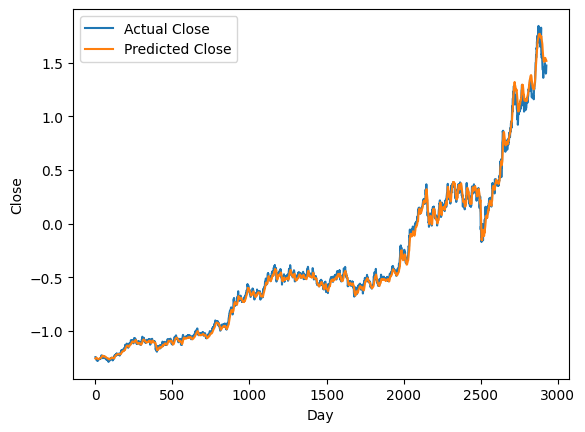

In [116]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


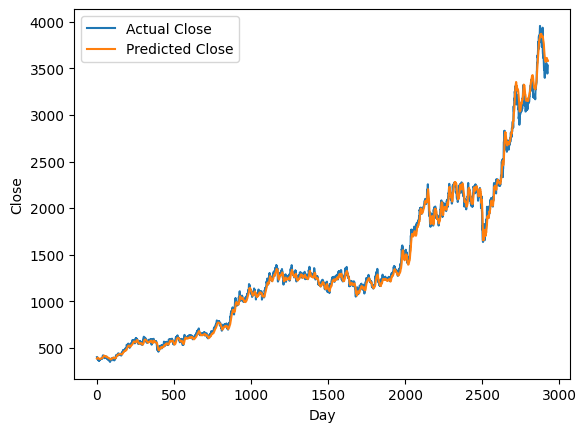

In [117]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


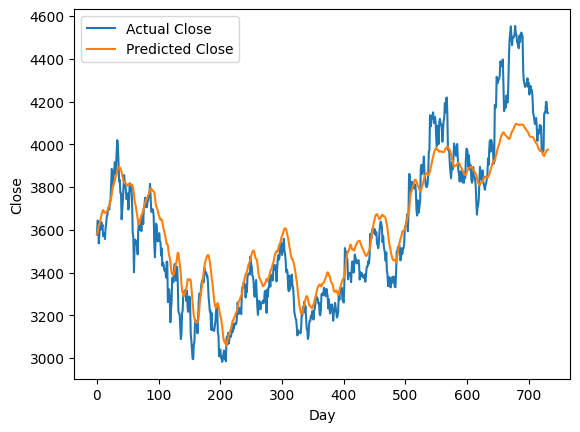

In [118]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()